# Financial index as the output of an ML model

In [657]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import randn, random, seed

In [658]:
%config InlineBackend.figure_format = "retina"

In [659]:
seed(3141)
n_components = 20
S0 = np.abs(100 + randn(20) * 100)

$$
    S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right)
$$

In [660]:
seed(314)
n_steps = 365 * 2
t = np.linspace(0,3,n_steps)
mus = np.abs(randn(n_components) * 0.2)
sigmas = np.abs(randn(n_components) * 0.45) + 0.1
dt = 1 / 365

In [661]:
St = (np.exp((mus[None, :] - sigmas[None, :] ** 2 / 2) * dt +
             sigmas[None, :] * randn(n_steps, n_components) * np.sqrt(dt)))
index = pd.date_range("2019-01-01", periods=n_steps)
St = pd.DataFrame(St, index=index)
St = S0[None, :] * St.cumprod(axis=0)

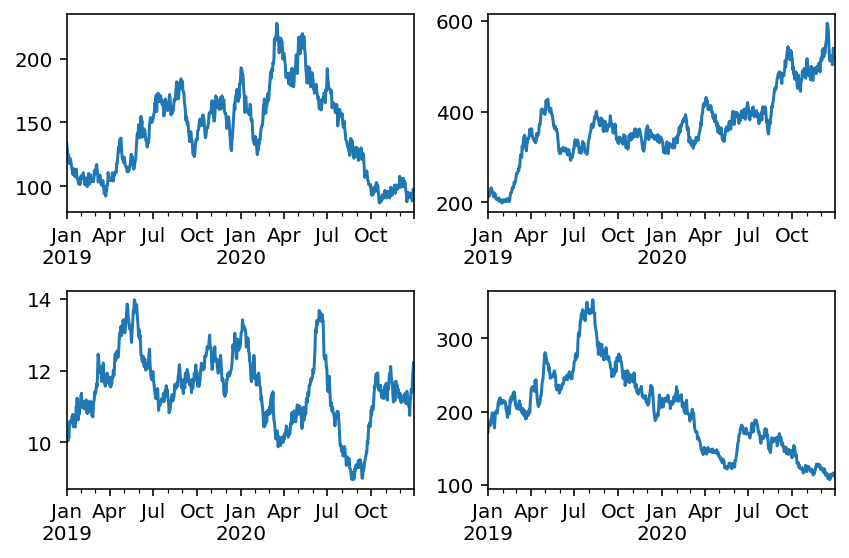

In [662]:
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
choices = [18, 2, 14, 19]

for axi, ix in zip(ax, choices):
    St[ix].plot(ax=axi)
plt.tight_layout()

In [663]:
from numpy.random import beta

In [664]:
seed(3141)
weights = beta(2, 5, n_components)
weights = weights / weights.sum()

In [665]:
etf = (St.diff(axis=0).fillna(100) * weights[None, :]).cumsum(axis=0).sum(axis=1)
etf.name = "ETF"

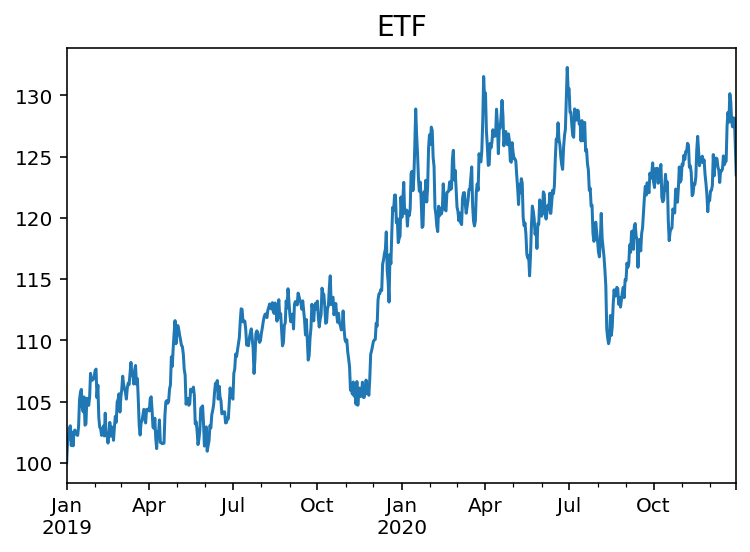

In [666]:
etf.plot()
plt.title("ETF", fontsize=14);

## Fitting an ML model to the ETF

In [748]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

returns = St.diff().dropna()
X = returns.join(etf.diff()[1:])

Xtrain = X[:-100]
Xtrain, ytrain = Xtrain.drop("ETF", axis=1), Xtrain["ETF"]

Xtest = X[-100:]
Xtest, ytest = Xtest.drop("ETF", axis=1), Xtest["ETF"]

In [733]:
params_el = {
    "alpha": [0.1, 0.5, 1],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7],

}

params_rf = {
    "n_estimators": [50, 100, 500],
    "max_features": [2, 5, 10, "auto"]
}

In [734]:
model_el = GridSearchCV(ElasticNet(), param_grid=params_el)
model_rf = GridSearchCV(RandomForestRegressor(), param_grid=params_rf)
model_lr = LinearRegression()

In [735]:
model_el.fit(Xtrain, ytrain)
model_rf.fit(Xtrain, ytrain)
model_lr.fit(Xtrain, ytrain)

LinearRegression()

In [736]:
yhat_el = model_el.predict(Xtest)
yhat_rf = model_rf.predict(Xtest)
yhat_lr = model_lr.predict(Xtest)

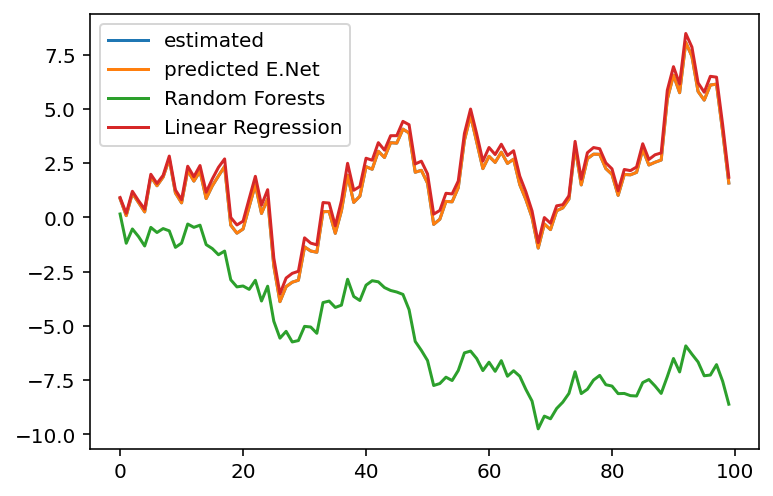

In [740]:
fig, ax = plt.subplots(1, 1)
ax.plot(yhat.cumsum(), label="estimated")
plt.plot(yhat_el.cumsum(), label="predicted E.Net")
plt.plot(yhat_rf.cumsum(), label="Random Forests")
plt.plot(yhat_lr.cumsum(), label="Linear Regression")
plt.legend()

In [750]:
yhat_el.cumsum() - ytest.cumsum()

2020-09-22   -0.049807
2020-09-23   -0.105573
2020-09-24   -0.091207
2020-09-25   -0.083023
2020-09-26   -0.128653
                ...   
2020-12-26   -0.364473
2020-12-27   -0.400790
2020-12-28   -0.321007
2020-12-29   -0.317176
2020-12-30   -0.264425
Freq: D, Name: ETF, Length: 100, dtype: float64